In [23]:
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import re
import seaborn as sns



nltk.download("punkt")
nltk.download("stopwords")

arabic_stopwords = set(stopwords.words("arabic"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Osman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Osman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
data_folder = "tashkeela_texts" 

# Read all text files from the corpus folder
texts = []
for filename in os.listdir(data_folder):
    if filename.endswith(".txt"):  
        with open(os.path.join(data_folder, filename), "r", encoding="utf-8") as file:
            texts.append(file.read())

# Store in a DataFrame
df = pd.DataFrame(texts, columns=["text"])
print(f"Loaded {len(df)} Arabic texts from Tashkeela corpus.")

# Display sample text
df.head()

Loaded 97 Arabic texts from Tashkeela corpus.


,text
0,هذا الملف آليا بواسطة المكتبة الشاملة\nالكتاب ...
1,بَابُ السِّحْرِ وَحُكْمُ السَّاحِرِ قَالَ اللّ...
2,﻿العنوان: أخلاق حملة القرآن\nالمؤلف: أبو بكر ا...
3,تم إعداد هذا الملف آليا بواسطة المكتبة الشامل...
4,تم إعداد هذا الملف آليا بواسطة المكتبة الشامل...


In [25]:
def compute_diacritic_ratio(text):

    diacritic_pattern = re.compile(r"[\u064B-\u0652]")  # Arabic diacritics range
    total_chars = len(text)
    diacritic_chars = len(diacritic_pattern.findall(text))
    
    return diacritic_chars / total_chars if total_chars > 0 else 0.0

In [26]:
word_freq_dist = FreqDist(nltk.word_tokenize(" ".join(df["text"])))

# Feature extraction function
def extract_features(text):
    words = word_tokenize(text)  # Tokenise words
    sentences = sent_tokenize(text)  # Tokenise sentences

    # Lexical Features
    avg_word_length = sum(len(word) for word in words) / max(len(words), 1)
    type_token_ratio = len(set(words)) / max(len(words), 1)
    syllable_count = sum(len([char for char in word if char in "اوي"]) for word in words) / max(len(words), 1)

    # Syntactic Features
    avg_sentence_length = len(words) / max(len(sentences), 1)
    punctuation_density = sum(1 for char in text if char in "،.؟!") / max(len(sentences), 1)

    # Stopword Ratio
    stopword_ratio = sum(1 for word in words if word in arabic_stopwords) / max(len(words), 1)

    # Word Frequency Score
    word_freq_score = sum(word_freq_dist.freq(word) for word in words) / max(len(words), 1)

    return {
        "avg_word_length": avg_word_length,
        "type_token_ratio": type_token_ratio,
        "syllable_count": syllable_count,
        "avg_sentence_length": avg_sentence_length,
        "punctuation_density": punctuation_density,
        "stopword_ratio": stopword_ratio,
        "word_freq_score": word_freq_score
    }

df_features = df["text"].apply(extract_features).apply(pd.Series)

df = pd.concat([df, df_features], axis=1)

df["diacritic_ratio"] = df["text"].apply(compute_diacritic_ratio)


df.head()


,text,avg_word_length,type_token_ratio,syllable_count,avg_sentence_length,punctuation_density,stopword_ratio,word_freq_score,diacritic_ratio
0,هذا الملف آليا بواسطة المكتبة الشاملة\nالكتاب ...,6.445922,0.125713,0.882080,33.039226,2.979360,0.000361,0.005032,0.381531
1,بَابُ السِّحْرِ وَحُكْمُ السَّاحِرِ قَالَ اللّ...,6.808326,0.348003,0.955565,71.333333,1.127273,0.000170,0.002852,0.388797
2,﻿العنوان: أخلاق حملة القرآن\nالمؤلف: أبو بكر ا...,6.677916,0.387313,0.841842,41.482353,5.682353,0.014180,0.002530,0.378176
3,تم إعداد هذا الملف آليا بواسطة المكتبة الشامل...,6.673759,0.276234,0.904007,26.248414,2.177112,0.000551,0.004329,0.387472
4,تم إعداد هذا الملف آليا بواسطة المكتبة الشامل...,6.754553,0.069248,0.919041,159.720181,3.501713,0.001454,0.004916,0.391079


In [27]:
feature_cols = ["avg_word_length", "type_token_ratio", "syllable_count",
                "avg_sentence_length", "punctuation_density", "stopword_ratio", "word_freq_score", "diacritic_ratio"]

In [28]:
# Compute readability score based on extracted features
df["readability_score"] = (
    4 * (1 - df["stopword_ratio"]) +
    3 * (df["avg_sentence_length"] / df["avg_sentence_length"].max()) +
    2 * (1 - df["word_freq_score"]) +
    1.5 * (df["syllable_count"] / df["syllable_count"].max()) +
    1.5 * (df["punctuation_density"] / df["punctuation_density"].max()) +
    2 * df["diacritic_ratio"]  
)

# Normalise readability score between 0-10
df["readability_score"] = np.interp(
    df["readability_score"],
    (df["readability_score"].min(), df["readability_score"].max()),
    (0, 10)
)

# Display sample readability scores
df[["text", "readability_score"]].head()


,text,readability_score
0,هذا الملف آليا بواسطة المكتبة الشاملة\nالكتاب ...,1.923540
1,بَابُ السِّحْرِ وَحُكْمُ السَّاحِرِ قَالَ اللّ...,2.144523
2,﻿العنوان: أخلاق حملة القرآن\nالمؤلف: أبو بكر ا...,1.783477
3,تم إعداد هذا الملف آليا بواسطة المكتبة الشامل...,1.991134
4,تم إعداد هذا الملف آليا بواسطة المكتبة الشامل...,2.143061


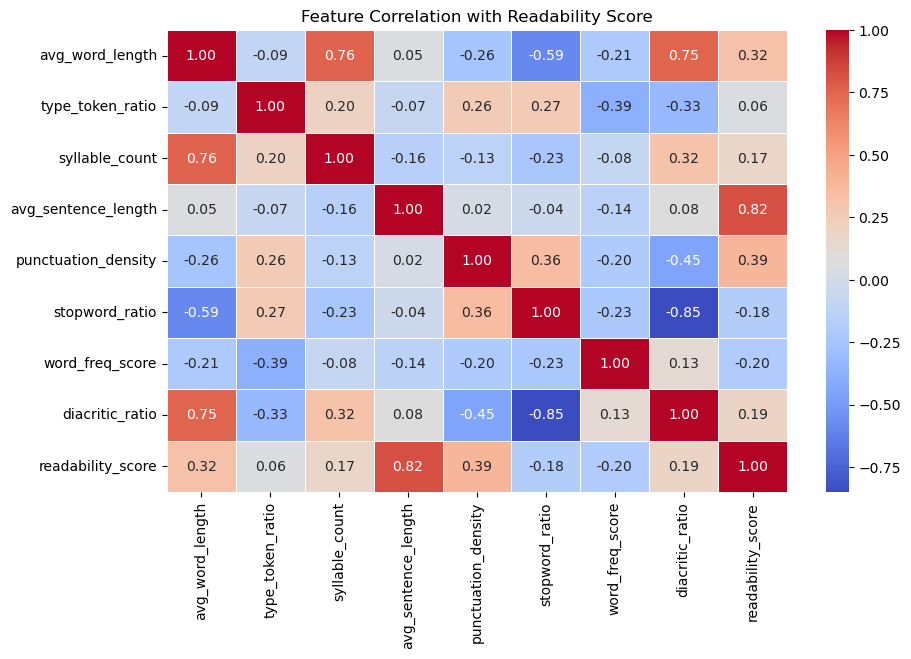

In [29]:
# Compute correlation matrix
correlation_matrix = df[feature_cols + ["readability_score"]].corr()

# Visualise correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation with Readability Score")
plt.show()

In [30]:
# Define feature columns based on correlation with readability score
feature_cols = ["avg_word_length", "punctuation_density", 
                "avg_sentence_length", "diacritic_ratio", "syllable_count"]  

# Ensure all required columns exist
existing_features = [col for col in feature_cols if col in df.columns]

# Convert only existing columns to numeric and handle errors
for col in existing_features:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill missing values with column means
df[existing_features] = df[existing_features].fillna(df[existing_features].mean())

print(df[existing_features].dtypes)

avg_word_length        float64
punctuation_density    float64
avg_sentence_length    float64
diacritic_ratio        float64
syllable_count         float64
dtype: object


In [31]:
# Define features and target variable
X = df[feature_cols]
y = df["readability_score"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Train Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100,      
    max_depth=6,          
    min_samples_split=5,   
    min_samples_leaf=5,    
    max_features="log2",   
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Display results
print(f"Random Forest Regressor: MSE = {mse_rf:.4f}, R² = {r2_rf:.4f}")

Random Forest Regressor: MSE = 2.8947, R² = 0.0819


In [33]:
# Train XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=500,    
    learning_rate=0.05,  
    max_depth=6,         
    colsample_bytree=1, 
    subsample=0.8,       
    reg_alpha=0.1,       
    reg_lambda=0.5,     
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Display results
print(f"XGBoost Regressor: MSE = {mse_xgb:.4f}, R² = {r2_xgb:.4f}")


XGBoost Regressor: MSE = 1.7511, R² = 0.4446


In [34]:
# Train MLP Regressor
mlp_model = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  
    activation="relu",  
    solver="adam",  
    alpha=0.01, 
    max_iter=1000,
    learning_rate_init=0.001,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_mlp = mlp_model.predict(X_test_scaled)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

# Display results
print(f"MLP Regressor: MSE = {mse_mlp:.4f}, R² = {r2_mlp:.4f}")


MLP Regressor: MSE = 0.5208, R² = 0.8348
